In [1]:
import numpy as np
import tensorflow as tf
from copy import deepcopy

import os
import re

import datetime

import import_ipynb
from QBert import train_utils, models

from tqdm.notebook import tqdm



importing Jupyter notebook from C:\Users\LGCNS\Documents\GitHub\Q_Bert\QBert\train_utils.ipynb
importing Jupyter notebook from C:\Users\LGCNS\Documents\GitHub\Q_Bert\QBert\models.ipynb


## 해당 파일은 bert.run_pretraining.run_bert_pretrain을 구현하는 것을 목표로 한다.

 - Parameter는 FLAG 형식에서 직접 정의해주는 방식으로 변경하고, Main에서 직접 정의하도록 한다.

## Strategy

In [2]:
tf.config.list_physical_devices() # device 확인

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:XLA_CPU:0', device_type='XLA_CPU'),
 PhysicalDevice(name='/physical_device:XLA_GPU:0', device_type='XLA_GPU')]

In [3]:
# Strategy 정의

distribution_strategy = 'mirrored' # 'tpu'
num_gpus = 0
all_reduce_alg = None

if distribution_strategy == 'tpu' :
    tpu_address = ""
else :
    tpu_address = None



strategy = train_utils.get_distribution_strategy(
                  distribution_strategy=distribution_strategy,
                  num_gpus=num_gpus,
                  all_reduce_alg=all_reduce_alg,
                  tpu_address=tpu_address)

print ('\n장치의 수: {}'.format(strategy.num_replicas_in_sync))

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)

장치의 수: 1


## Bert_Config

In [4]:
# sub_model (core_model 필요 Config)

vocab_size = 32000 # 
hidden_size = 768 # Transformer hidden Layers
type_vocab_size = 12 #: The number of types that the 'type_ids' input can take.
num_layers = 12
num_attention_heads = 12
max_seq_length = 256 # 512
dropout_rate = .1
# attention_dropout_rate = .1
inner_dim = 3072
# hidden_act = 'gelu'
initializer=tf.keras.initializers.TruncatedNormal(stddev=0.02)

# Pretrain Model 필요 Config
max_predictions_per_seq = 40


## Input_Files

In [5]:
filenames = ['./Test_Examples.tfrecords']

# Create a description of the features.
feature_description = {
    'input_ids': tf.io.FixedLenFeature([max_seq_length], tf.int64),
    'segment_ids': tf.io.FixedLenFeature([max_seq_length], tf.int64),
    'input_mask': tf.io.FixedLenFeature([max_seq_length], tf.int64),
    'masked_lm_positions': tf.io.FixedLenFeature([max_predictions_per_seq], tf.int64),
    'masked_lm_ids': tf.io.FixedLenFeature([max_predictions_per_seq], tf.int64),
    'masked_lm_weights': tf.io.FixedLenFeature([max_predictions_per_seq], tf.float32),
    'next_sentence_labels': tf.io.FixedLenFeature([1], tf.int64),
}

# keys = feature_description.keys()

In [6]:
def _parse_function(example_proto):
  # Parse the input `tf.train.Example` proto using the dictionary above.
  return tf.io.parse_single_example(example_proto, feature_description)

def _select_data_from_record(record):
    """Filter out features to use for pretraining."""
    x = {
        'input_ids': record['input_ids'],
        'input_mask': record['input_mask'],
        'segment_ids': record['segment_ids'],
        'masked_lm_positions': record['masked_lm_positions'],
        'masked_lm_ids': record['masked_lm_ids'],
        'masked_lm_weights': record['masked_lm_weights'],
    }
    if use_next_sentence_label:
        x['next_sentence_labels'] = record['next_sentence_labels']
    if use_position_id:
        x['position_ids'] = record['position_ids']

    # TODO(hongkuny): Remove the fake labels after migrating bert pretraining.
    if output_fake_labels:
        return (x, record['masked_lm_weights'])
    else:
        return x


In [7]:

BUFFER_SIZE = 100

GLOBAL_BATCH_SIZE = 2
BATCH_SIZE_PER_REPLICA = np.ceil(GLOBAL_BATCH_SIZE // strategy.num_replicas_in_sync)

use_next_sentence_label = True
output_fake_labels = True
use_position_id = False

lr = 1e-3


In [8]:

with strategy.scope():

    train_dataset = tf.data.Dataset.from_tensor_slices(filenames)
    train_dataset = train_dataset.interleave(tf.data.TFRecordDataset
                                             , cycle_length = tf.data.experimental.AUTOTUNE
                                             , num_parallel_calls = tf.data.experimental.AUTOTUNE)
    dataset_inputs = train_dataset.map(_parse_function,
                                       num_parallel_calls=tf.data.experimental.AUTOTUNE) # String to Example
    dataset_inputs_with_labels = dataset_inputs.map(_select_data_from_record,
                                                    num_parallel_calls=tf.data.experimental.AUTOTUNE) # Example to InputData
    ## 본래대로라면 그냥 써도 되지만, 현재 Label이 없는 데이터이기 때문에
    ## max_predictions_per_seq 길이의 허위 정답 (Fake_y)를 삽입하는 mapping function이다.

    dataset = dataset_inputs_with_labels
    dataset = dataset.cache()
    dataset = dataset.repeat()
    dataset = dataset.shuffle(10000, reshuffle_each_iteration = True)
    dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)
    dataset = dataset.batch(GLOBAL_BATCH_SIZE)
    
    dist_dataset = strategy.experimental_distribute_dataset(dataset)

## Traning Config

In [9]:
# callback

## model checkpoint
t = datetime.datetime.now().strftime("%Y%m%d%H%M%S")

checkpoint_dir = './training_checkpoints_{}'.format(t)
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")

model_cp = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_prefix, save_weights_only=True),

## Learning Rate Print

class PrintLR(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        print('\n에포크 {}의 학습률은 {}입니다.'.format(epoch + 1,
                                                      model.optimizer.lr.numpy()))

callbacks = [model_cp]

In [10]:
# optimizer

## Learning Rate Decay

# lr = 1e-4 warmup stage (step <= 10000)
# Decay linearly

init_lr = 1e-4
warmup_steps = 10000
num_train_steps = 1000000
end_lr = 0

lr_schedule = tf.keras.optimizers.schedules.PolynomialDecay(
      initial_learning_rate=init_lr,
      decay_steps=num_train_steps,
      end_learning_rate=end_lr)

lr_schedule = train_utils.WarmUp(
        initial_learning_rate=init_lr,
        decay_schedule_fn=lr_schedule,
        warmup_steps=warmup_steps)

optimizer = train_utils.AdamWeightDecay( 
    learning_rate=lr_schedule,
    weight_decay_rate=0.01,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-6,
    exclude_from_weight_decay=['LayerNorm', 'layer_norm', 'bias'])

In [11]:
# loss
def loss_fn(fake_y, losses, **unused_args) :
    
    return tf.reduce_mean(losses, axis = -1)
    

## Model Define

In [12]:
with strategy.scope() :

    model, sub_model = models.get_bert_models_fn(vocab_size
                                             , hidden_size
                                             , type_vocab_size
                                             , num_layers
                                             , num_attention_heads
                                             , max_seq_length
                                             , max_predictions_per_seq
                                             , dropout_rate
                                             , inner_dim 
                                             , initializer)
    model.compile(optimizer, loss=loss_fn)

# 훈련

In [13]:
def _replicated_step(inputs):
    """Replicated training step."""

    inputs, labels = inputs
    
    with tf.GradientTape() as tape:
        
        model_outputs = model(inputs, training=True)
        loss = loss_fn(labels, model_outputs)
        # Raw loss is used for reporting in metrics/logs.
        raw_loss = loss
    
        if scale_loss:
            # Scales down the loss for gradients to be invariant from replicas.
            loss = loss / strategy.num_replicas_in_sync

    if isinstance(optimizer, tf.keras.mixed_precision.experimental.LossScaleOptimizer):
        
        with tape:
            scaled_loss = optimizer.get_scaled_loss(loss)
        scaled_grads = tape.gradient(scaled_loss, training_vars)
        grads = optimizer.get_unscaled_gradients(scaled_grads)
        
    else:
        
        grads = tape.gradient(loss, training_vars)
        optimizer.apply_gradients(zip(grads, training_vars))
    
    # For reporting, the metric takes the mean of losses.
    train_loss_metric.update_state(raw_loss)
    
    for metric in train_metrics:
        metric.update_state(labels, model_outputs)

In [14]:
@tf.function
def train_step(iterator, steps):
    
#     def step_fn(inputs):
#         features, labels = inputs

#         with tf.GradientTape() as tape:
            
#             losses = model(features)    
#             losses = losses * (1.0 / GLOBAL_BATCH_SIZE)

#         grads = tape.gradient(losses, model.trainable_variables)
#         optimizer.apply_gradients(list(zip(grads, model.trainable_variables)))
        
#         return losses

    if not isinstance(steps, tf.Tensor):
        raise ValueError('steps should be an Tensor. Python object may cause '
                     'retracing.')

    for _ in tf.range(steps):
        strategy.run(_replicated_step, args=(next(iterator),))

In [15]:
def train_single_step(iterator):
    """Performs a distributed training step.

    Args:
    iterator: the distributed iterator of training datasets.

    Raises:
    ValueError: Any of the arguments or tensor shapes are invalid.
    """
    strategy.run(_replicated_step, args=(next(iterator),))

In [16]:
def steps_to_run(current_step, steps_per_epoch, steps_per_loop):
    """Calculates steps to run on device."""
    if steps_per_loop <= 0:
        raise ValueError('steps_per_loop should be positive integer.')
    if steps_per_loop == 1:
        return steps_per_loop
    remainder_in_epoch = current_step % steps_per_epoch
    if remainder_in_epoch != 0:
        return min(steps_per_epoch - remainder_in_epoch, steps_per_loop)
    else:
        return steps_per_loop

In [17]:
train_single_step = tf.function(train_single_step)

In [49]:
steps_per_epoch = 25 #25000
steps_between_evals = 25 #
steps_per_loop = 1
epochs = 50

total_training_steps = steps_per_epoch * epochs
eval_loss_metric = tf.keras.metrics.Mean('traning loss', dtype = tf.float32)
train_loss_metric = tf.keras.metrics.Mean('traning loss', dtype = tf.float32)

scale_loss = True if strategy.num_replicas_in_sync > 1 else False

In [50]:
# Data Set
train_iterator = iter(dist_dataset)

In [51]:

train_metrics = model.metrics
train_loss_metric = tf.keras.metrics.Mean('training_loss', dtype=tf.float32)

# callbacks = tf.keras.callbacks.CallbackList(callbacks) # tf 2.5.0 제공
optimizer = model.optimizer
training_vars = model.trainable_variables

# Callback
for cb in callbacks :
    cb[0].model = model


In [53]:
current_step = optimizer.iterations.numpy()
current_step

250

In [ ]:
history = {}

for cb in callbacks :
    cb[0].on_train_begin()

while current_step < total_training_steps and not model.stop_training :
    if (current_step % steps_per_epoch == 0) :
        print("{} EPOCH BEGIN".format(int(current_step // steps_per_epoch) + 1))
        for cb in callbacks :
            cb[0].on_epoch_begin(int(current_step // steps_per_epoch) + 1)

    for cb in callbacks :
        print("BATCH_BEGIN - {}".format(current_step))
        cb[0].on_batch_begin(current_step)
        
    steps = steps_to_run(current_step, steps_between_evals, steps_per_loop)
    
    if tf.config.list_physical_devices('GPU') :
        for _ in steps :
            train_single_step(train_iterator)
    else :
        train_step(train_iterator, tf.convert_to_tensor(steps, dtype = tf.int32))

    train_loss = train_loss_metric.result().numpy().astype(float)
    current_step += steps

    logs = {'training_loss' : train_loss}

    for t_metric in train_metrics :
        logs[t_metric.name] = t_metric.result().numpy()

    for key in logs.keys() :
        if key in history.keys() :
            history[key].append(logs[key])
        else :
            history[key] = [logs[key]]

    training_status = 'Train Step: %d/%d  \n - LOGS - \n'%(current_step, total_training_steps)
    
    for key in logs.keys() :
        training_status += "{} : {:.4f}, ".format(key, logs[key])

    print(training_status)

    if current_step % steps_between_evals:
        for cb in callbacks :
            print("BATCH_END - {}".format(current_step - 1))
            cb[0].on_batch_end(current_step - 1, {'loss': train_loss})

    if current_step % steps_per_epoch == 0:
        for cb in callbacks :
            print("{} EPOCH_END".format(int(current_step / steps_per_epoch)))
            cb[0].on_epoch_end(int(current_step / steps_per_epoch), logs)
            
    print()
for cb in callbacks :
    cb[0].on_train_end()

11 EPOCH BEGIN
BATCH_BEGIN - 250
Train Step: 251/1250  
 - LOGS - 
training_loss : 0.0000, MLM_ACC : 0.6028, MLM_LOSS : 0.6141, NSP_ACC : 0.6032, NSP_LOSS : 0.6039, 
BATCH_END - 250

BATCH_BEGIN - 251
Train Step: 252/1250  
 - LOGS - 
training_loss : 0.0000, MLM_ACC : 0.6041, MLM_LOSS : 0.6155, NSP_ACC : 0.6046, NSP_LOSS : 0.6053, 
BATCH_END - 251

BATCH_BEGIN - 252
Train Step: 253/1250  
 - LOGS - 
training_loss : 0.0000, MLM_ACC : 0.6048, MLM_LOSS : 0.6162, NSP_ACC : 0.6053, NSP_LOSS : 0.6059, 
BATCH_END - 252

BATCH_BEGIN - 253
Train Step: 254/1250  
 - LOGS - 
training_loss : 0.0000, MLM_ACC : 0.6058, MLM_LOSS : 0.6172, NSP_ACC : 0.6063, NSP_LOSS : 0.6069, 
BATCH_END - 253

BATCH_BEGIN - 254
Train Step: 255/1250  
 - LOGS - 
training_loss : 0.0000, MLM_ACC : 0.6056, MLM_LOSS : 0.6170, NSP_ACC : 0.6061, NSP_LOSS : 0.6067, 
BATCH_END - 254

BATCH_BEGIN - 255
Train Step: 256/1250  
 - LOGS - 
training_loss : 0.0000, MLM_ACC : 0.6069, MLM_LOSS : 0.6183, NSP_ACC : 0.6073, NSP_LOSS : 0.6


13 EPOCH BEGIN
BATCH_BEGIN - 300
Train Step: 301/1250  
 - LOGS - 
training_loss : 0.0000, MLM_ACC : 0.6087, MLM_LOSS : 0.6201, NSP_ACC : 0.6092, NSP_LOSS : 0.6098, 
BATCH_END - 300

BATCH_BEGIN - 301
Train Step: 302/1250  
 - LOGS - 
training_loss : 0.0000, MLM_ACC : 0.6097, MLM_LOSS : 0.6211, NSP_ACC : 0.6102, NSP_LOSS : 0.6108, 
BATCH_END - 301

BATCH_BEGIN - 302
Train Step: 303/1250  
 - LOGS - 
training_loss : 0.0000, MLM_ACC : 0.6092, MLM_LOSS : 0.6206, NSP_ACC : 0.6097, NSP_LOSS : 0.6102, 
BATCH_END - 302

BATCH_BEGIN - 303
Train Step: 304/1250  
 - LOGS - 
training_loss : 0.0000, MLM_ACC : 0.6081, MLM_LOSS : 0.6195, NSP_ACC : 0.6086, NSP_LOSS : 0.6092, 
BATCH_END - 303

BATCH_BEGIN - 304
Train Step: 305/1250  
 - LOGS - 
training_loss : 0.0000, MLM_ACC : 0.6081, MLM_LOSS : 0.6195, NSP_ACC : 0.6086, NSP_LOSS : 0.6091, 
BATCH_END - 304

BATCH_BEGIN - 305
Train Step: 306/1250  
 - LOGS - 
training_loss : 0.0000, MLM_ACC : 0.6091, MLM_LOSS : 0.6206, NSP_ACC : 0.6096, NSP_LOSS : 0.

Train Step: 350/1250  
 - LOGS - 
training_loss : 0.0000, MLM_ACC : 0.6073, MLM_LOSS : 0.6187, NSP_ACC : 0.6078, NSP_LOSS : 0.6084, 
14 EPOCH_END

15 EPOCH BEGIN
BATCH_BEGIN - 350
Train Step: 351/1250  
 - LOGS - 
training_loss : 0.0000, MLM_ACC : 0.6075, MLM_LOSS : 0.6189, NSP_ACC : 0.6080, NSP_LOSS : 0.6086, 
BATCH_END - 350

BATCH_BEGIN - 351
Train Step: 352/1250  
 - LOGS - 
training_loss : 0.0000, MLM_ACC : 0.6077, MLM_LOSS : 0.6191, NSP_ACC : 0.6082, NSP_LOSS : 0.6088, 
BATCH_END - 351

BATCH_BEGIN - 352
Train Step: 353/1250  
 - LOGS - 
training_loss : 0.0000, MLM_ACC : 0.6077, MLM_LOSS : 0.6191, NSP_ACC : 0.6081, NSP_LOSS : 0.6088, 
BATCH_END - 352

BATCH_BEGIN - 353
Train Step: 354/1250  
 - LOGS - 
training_loss : 0.0000, MLM_ACC : 0.6077, MLM_LOSS : 0.6191, NSP_ACC : 0.6081, NSP_LOSS : 0.6087, 
BATCH_END - 353

BATCH_BEGIN - 354
Train Step: 355/1250  
 - LOGS - 
training_loss : 0.0000, MLM_ACC : 0.6074, MLM_LOSS : 0.6188, NSP_ACC : 0.6079, NSP_LOSS : 0.6085, 
BATCH_END - 354

Train Step: 399/1250  
 - LOGS - 
training_loss : 0.0000, MLM_ACC : 0.6125, MLM_LOSS : 0.6239, NSP_ACC : 0.6129, NSP_LOSS : 0.6135, 
BATCH_END - 398

BATCH_BEGIN - 399
Train Step: 400/1250  
 - LOGS - 
training_loss : 0.0000, MLM_ACC : 0.6120, MLM_LOSS : 0.6234, NSP_ACC : 0.6125, NSP_LOSS : 0.6131, 
16 EPOCH_END

17 EPOCH BEGIN
BATCH_BEGIN - 400
Train Step: 401/1250  
 - LOGS - 
training_loss : 0.0000, MLM_ACC : 0.6112, MLM_LOSS : 0.6226, NSP_ACC : 0.6117, NSP_LOSS : 0.6123, 
BATCH_END - 400

BATCH_BEGIN - 401
Train Step: 402/1250  
 - LOGS - 
training_loss : 0.0000, MLM_ACC : 0.6110, MLM_LOSS : 0.6224, NSP_ACC : 0.6115, NSP_LOSS : 0.6121, 
BATCH_END - 401

BATCH_BEGIN - 402
Train Step: 403/1250  
 - LOGS - 
training_loss : 0.0000, MLM_ACC : 0.6108, MLM_LOSS : 0.6222, NSP_ACC : 0.6113, NSP_LOSS : 0.6118, 
BATCH_END - 402

BATCH_BEGIN - 403
Train Step: 404/1250  
 - LOGS - 
training_loss : 0.0000, MLM_ACC : 0.6101, MLM_LOSS : 0.6216, NSP_ACC : 0.6106, NSP_LOSS : 0.6112, 
BATCH_END - 403

Train Step: 448/1250  
 - LOGS - 
training_loss : 0.0000, MLM_ACC : 0.6159, MLM_LOSS : 0.6273, NSP_ACC : 0.6164, NSP_LOSS : 0.6170, 
BATCH_END - 447

BATCH_BEGIN - 448
Train Step: 449/1250  
 - LOGS - 
training_loss : 0.0000, MLM_ACC : 0.6158, MLM_LOSS : 0.6272, NSP_ACC : 0.6163, NSP_LOSS : 0.6169, 
BATCH_END - 448

BATCH_BEGIN - 449
Train Step: 450/1250  
 - LOGS - 
training_loss : 0.0000, MLM_ACC : 0.6162, MLM_LOSS : 0.6276, NSP_ACC : 0.6167, NSP_LOSS : 0.6173, 
18 EPOCH_END

19 EPOCH BEGIN
BATCH_BEGIN - 450
Train Step: 451/1250  
 - LOGS - 
training_loss : 0.0000, MLM_ACC : 0.6169, MLM_LOSS : 0.6283, NSP_ACC : 0.6174, NSP_LOSS : 0.6180, 
BATCH_END - 450

BATCH_BEGIN - 451
Train Step: 452/1250  
 - LOGS - 
training_loss : 0.0000, MLM_ACC : 0.6172, MLM_LOSS : 0.6286, NSP_ACC : 0.6177, NSP_LOSS : 0.6183, 
BATCH_END - 451

BATCH_BEGIN - 452
Train Step: 453/1250  
 - LOGS - 
training_loss : 0.0000, MLM_ACC : 0.6170, MLM_LOSS : 0.6285, NSP_ACC : 0.6175, NSP_LOSS : 0.6181, 
BATCH_END - 452

Train Step: 497/1250  
 - LOGS - 
training_loss : 0.0000, MLM_ACC : 0.6100, MLM_LOSS : 0.6214, NSP_ACC : 0.6105, NSP_LOSS : 0.6111, 
BATCH_END - 496

BATCH_BEGIN - 497
Train Step: 498/1250  
 - LOGS - 
training_loss : 0.0000, MLM_ACC : 0.6095, MLM_LOSS : 0.6209, NSP_ACC : 0.6099, NSP_LOSS : 0.6106, 
BATCH_END - 497

BATCH_BEGIN - 498
Train Step: 499/1250  
 - LOGS - 
training_loss : 0.0000, MLM_ACC : 0.6097, MLM_LOSS : 0.6211, NSP_ACC : 0.6102, NSP_LOSS : 0.6109, 
BATCH_END - 498

BATCH_BEGIN - 499
Train Step: 500/1250  
 - LOGS - 
training_loss : 0.0000, MLM_ACC : 0.6105, MLM_LOSS : 0.6218, NSP_ACC : 0.6109, NSP_LOSS : 0.6116, 
20 EPOCH_END

21 EPOCH BEGIN
BATCH_BEGIN - 500
Train Step: 501/1250  
 - LOGS - 
training_loss : 0.0000, MLM_ACC : 0.6111, MLM_LOSS : 0.6224, NSP_ACC : 0.6115, NSP_LOSS : 0.6122, 
BATCH_END - 500

BATCH_BEGIN - 501
Train Step: 502/1250  
 - LOGS - 
training_loss : 0.0000, MLM_ACC : 0.6112, MLM_LOSS : 0.6226, NSP_ACC : 0.6117, NSP_LOSS : 0.6123, 
BATCH_END - 501

Train Step: 546/1250  
 - LOGS - 
training_loss : 0.0000, MLM_ACC : 0.6119, MLM_LOSS : 0.6233, NSP_ACC : 0.6124, NSP_LOSS : 0.6130, 
BATCH_END - 545

BATCH_BEGIN - 546
Train Step: 547/1250  
 - LOGS - 
training_loss : 0.0000, MLM_ACC : 0.6121, MLM_LOSS : 0.6235, NSP_ACC : 0.6126, NSP_LOSS : 0.6132, 
BATCH_END - 546

BATCH_BEGIN - 547
Train Step: 548/1250  
 - LOGS - 
training_loss : 0.0000, MLM_ACC : 0.6120, MLM_LOSS : 0.6234, NSP_ACC : 0.6125, NSP_LOSS : 0.6131, 
BATCH_END - 547

BATCH_BEGIN - 548
Train Step: 549/1250  
 - LOGS - 
training_loss : 0.0000, MLM_ACC : 0.6125, MLM_LOSS : 0.6239, NSP_ACC : 0.6130, NSP_LOSS : 0.6136, 
BATCH_END - 548

BATCH_BEGIN - 549
Train Step: 550/1250  
 - LOGS - 
training_loss : 0.0000, MLM_ACC : 0.6127, MLM_LOSS : 0.6241, NSP_ACC : 0.6132, NSP_LOSS : 0.6138, 
22 EPOCH_END

23 EPOCH BEGIN
BATCH_BEGIN - 550
Train Step: 551/1250  
 - LOGS - 
training_loss : 0.0000, MLM_ACC : 0.6127, MLM_LOSS : 0.6241, NSP_ACC : 0.6132, NSP_LOSS : 0.6138, 
BATCH_END - 550

Train Step: 595/1250  
 - LOGS - 
training_loss : 0.0000, MLM_ACC : 0.6147, MLM_LOSS : 0.6261, NSP_ACC : 0.6152, NSP_LOSS : 0.6158, 
BATCH_END - 594

BATCH_BEGIN - 595
Train Step: 596/1250  
 - LOGS - 
training_loss : 0.0000, MLM_ACC : 0.6146, MLM_LOSS : 0.6260, NSP_ACC : 0.6151, NSP_LOSS : 0.6157, 
BATCH_END - 595

BATCH_BEGIN - 596
Train Step: 597/1250  
 - LOGS - 
training_loss : 0.0000, MLM_ACC : 0.6146, MLM_LOSS : 0.6260, NSP_ACC : 0.6151, NSP_LOSS : 0.6157, 
BATCH_END - 596

BATCH_BEGIN - 597
Train Step: 598/1250  
 - LOGS - 
training_loss : 0.0000, MLM_ACC : 0.6145, MLM_LOSS : 0.6259, NSP_ACC : 0.6150, NSP_LOSS : 0.6156, 
BATCH_END - 597

BATCH_BEGIN - 598
Train Step: 599/1250  
 - LOGS - 
training_loss : 0.0000, MLM_ACC : 0.6147, MLM_LOSS : 0.6261, NSP_ACC : 0.6152, NSP_LOSS : 0.6158, 
BATCH_END - 598

BATCH_BEGIN - 599
Train Step: 600/1250  
 - LOGS - 
training_loss : 0.0000, MLM_ACC : 0.6145, MLM_LOSS : 0.6259, NSP_ACC : 0.6150, NSP_LOSS : 0.6156, 
24 EPOCH_END

25 EPOCH BEGI

Train Step: 644/1250  
 - LOGS - 
training_loss : 0.0000, MLM_ACC : 0.6176, MLM_LOSS : 0.6290, NSP_ACC : 0.6181, NSP_LOSS : 0.6187, 
BATCH_END - 643

BATCH_BEGIN - 644
Train Step: 645/1250  
 - LOGS - 
training_loss : 0.0000, MLM_ACC : 0.6171, MLM_LOSS : 0.6285, NSP_ACC : 0.6176, NSP_LOSS : 0.6182, 
BATCH_END - 644

BATCH_BEGIN - 645
Train Step: 646/1250  
 - LOGS - 
training_loss : 0.0000, MLM_ACC : 0.6166, MLM_LOSS : 0.6279, NSP_ACC : 0.6171, NSP_LOSS : 0.6177, 
BATCH_END - 645

BATCH_BEGIN - 646
Train Step: 647/1250  
 - LOGS - 
training_loss : 0.0000, MLM_ACC : 0.6158, MLM_LOSS : 0.6272, NSP_ACC : 0.6163, NSP_LOSS : 0.6170, 
BATCH_END - 646

BATCH_BEGIN - 647
Train Step: 648/1250  
 - LOGS - 
training_loss : 0.0000, MLM_ACC : 0.6155, MLM_LOSS : 0.6268, NSP_ACC : 0.6160, NSP_LOSS : 0.6166, 
BATCH_END - 647

BATCH_BEGIN - 648
Train Step: 649/1250  
 - LOGS - 
training_loss : 0.0000, MLM_ACC : 0.6150, MLM_LOSS : 0.6264, NSP_ACC : 0.6155, NSP_LOSS : 0.6161, 
BATCH_END - 648

BATCH_BEGI

Train Step: 693/1250  
 - LOGS - 
training_loss : 0.0000, MLM_ACC : 0.6137, MLM_LOSS : 0.6250, NSP_ACC : 0.6142, NSP_LOSS : 0.6148, 
BATCH_END - 692

BATCH_BEGIN - 693
Train Step: 694/1250  
 - LOGS - 
training_loss : 0.0000, MLM_ACC : 0.6141, MLM_LOSS : 0.6255, NSP_ACC : 0.6146, NSP_LOSS : 0.6153, 
BATCH_END - 693

BATCH_BEGIN - 694
Train Step: 695/1250  
 - LOGS - 
training_loss : 0.0000, MLM_ACC : 0.6144, MLM_LOSS : 0.6257, NSP_ACC : 0.6149, NSP_LOSS : 0.6155, 
BATCH_END - 694

BATCH_BEGIN - 695
Train Step: 696/1250  
 - LOGS - 
training_loss : 0.0000, MLM_ACC : 0.6146, MLM_LOSS : 0.6259, NSP_ACC : 0.6151, NSP_LOSS : 0.6157, 
BATCH_END - 695

BATCH_BEGIN - 696
Train Step: 697/1250  
 - LOGS - 
training_loss : 0.0000, MLM_ACC : 0.6144, MLM_LOSS : 0.6258, NSP_ACC : 0.6150, NSP_LOSS : 0.6156, 
BATCH_END - 696

BATCH_BEGIN - 697
Train Step: 698/1250  
 - LOGS - 
training_loss : 0.0000, MLM_ACC : 0.6146, MLM_LOSS : 0.6260, NSP_ACC : 0.6152, NSP_LOSS : 0.6158, 
BATCH_END - 697

BATCH_BEGI

In [28]:
import matplotlib.pyplot as plt
%matplotlib inline

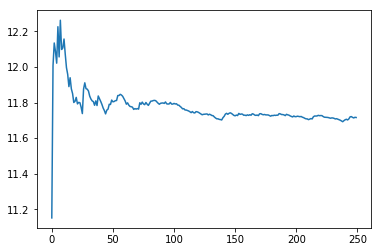

In [29]:
plt.plot(history['training_loss'])
plt.show()

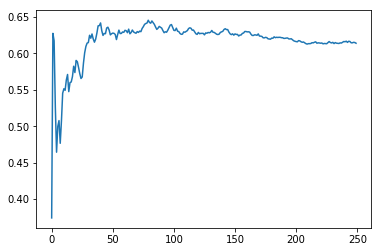

In [31]:
plt.plot(history['MLM_LOSS'])
plt.show()

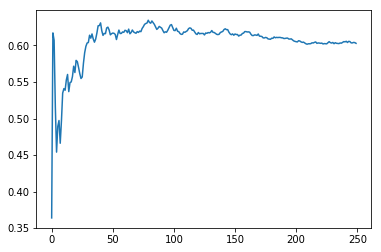

In [32]:
plt.plot(history['NSP_ACC'])
plt.show()

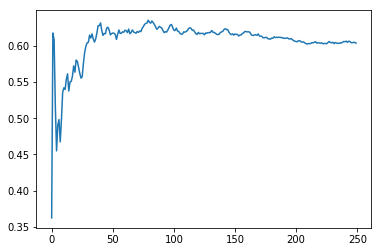

In [33]:
plt.plot(history['NSP_LOSS'])
plt.show()

In [35]:
#Test

In [36]:
inputs, labels = next(iter(dataset))

In [37]:
sub_res = sub_model([inputs['input_ids'], inputs['input_mask'][:, tf.newaxis, tf.newaxis, :], inputs['segment_ids']])

In [38]:
layer_x = model.layers[6]
layer_x._output_type = 'predicitions'

In [39]:
output_logits = layer_x([sub_res['sequence_output'], tf.cast(inputs['masked_lm_positions'], dtype = tf.int32)])

In [40]:
prediction = tf.math.exp(output_logits)

In [41]:
tf.argmax(prediction[0], axis = 1)

<tf.Tensor: shape=(40,), dtype=int64, numpy=
array([18107, 13143, 28954,  7298, 18576, 16403,  6968, 25705, 10808,
       15261, 21295,  5490, 23695, 26680, 29248, 29065, 12442, 12442,
       12442, 12442, 12442, 12442, 12442, 12442, 12442, 12442, 12442,
       12442, 12442, 12442, 12442, 12442, 12442, 12442, 12442, 12442,
       12442, 12442, 12442, 12442], dtype=int64)>

In [42]:
inputs['masked_lm_ids'][0]

<tf.Tensor: shape=(40,), dtype=int64, numpy=
array([ 5587, 13174,  8540,    15,  6031, 21126,   233,  3167,  3095,
        6227,  6480,  3167,  3053,  3010,  5719,  1539,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0], dtype=int64)>

In [43]:
from transformers import BertTokenizerFast
tokenizer_for_load = BertTokenizerFast.from_pretrained('./model/BertTokenizer-3000-32000-vocab.txt'
                                                   , strip_accents=False
                                                   , lowercase=False)

Calling BertTokenizerFast.from_pretrained() with the path to a single file or url is deprecated


In [48]:
print(tokenizer_for_load.convert_ids_to_tokens(tf.argmax(prediction[1], axis = 1)))

['머', '포츠', '부른', '##료', '##담', '길을', '6일', '4승', '눋', '##았던', '##참찬', '도망', '브뤼', '도요', '나라가', '역사학자', '역사학자', '역사학자', '역사학자', '역사학자', '역사학자', '역사학자', '역사학자', '역사학자', '역사학자', '역사학자', '역사학자', '역사학자', '역사학자', '역사학자', '역사학자', '역사학자', '역사학자', '역사학자', '역사학자', '역사학자', '역사학자', '역사학자', '역사학자', '역사학자']


In [47]:
print(tokenizer_for_load.convert_ids_to_tokens(inputs['masked_lm_ids'][1]))

[')', '-', '##병원', '##이며', '##전투', '##이다', '비영리', '현재는', '상태에서', '##에', '##ital', '##d', '보병', '.', '성', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]']


In [ ]:
lm_labels = inputs['masked_lm_ids'][0]
lm_output = output_logits[0]
lm_label_weights = inputs['masked_lm_weights'][0]

In [ ]:
masked_lm_accuracy = tf.keras.metrics.sparse_categorical_accuracy(lm_labels, lm_output)
numerator = tf.reduce_sum(masked_lm_accuracy * lm_label_weights)
denominator = tf.reduce_sum(lm_label_weights) + 1e-5
masked_lm_accuracy = numerator / denominator